# Dynamic Programming - Group 'Lost in Optimization' - Main python notebook

Install dependencies and set magics:

In [1]:
%load_ext autoreload
%autoreload 2

#%pip install EconModel
#%pip install ConSav
#%pip install quantecon

import time
import numpy as np
import numba as nb
nb.set_num_threads(4) #perhaps set to 8

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

## Initial solve of the models

Set amount of periods:

In [2]:
T = 5

Solve model with VFI:

In [5]:
model_vfi = DurableConsumptionModelClass(name='example_vfi',par={'solmethod':'vfi','T':T,'do_print':False})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()

Solve model with NVFI:

In [4]:
model_nvfi = DurableConsumptionModelClass(name='example_nvfi',par={'solmethod':'nvfi','T':T,'do_print':False})
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()
model_nvfi.save()

Solve model with NEGM:

In [3]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','T':T,'do_print':False})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()
model_negm.save()

Now possible to compare solutions:

In [ ]:
from figs import lifecycle_compare
lifecycle_compare(model_negm,'negm',model_nvfi,'nvfi')
lifecycle_compare(model_negm,'negm',model_vfi,'vfi')

In [ ]:
model_negm.lifecycle()

## Timing the model solution methods

### Timing function

In [18]:
def run(name = 'baseline',
        rep = 1, # set to 5 in the paper
        load = False,
        solmethod = 'negm',
        updpar = {},
        do_simple_wq = False,
        do_print = False):
    
    # a. create model
    par = {'solmethod':solmethod,'do_print':do_print,'do_simple_wq':do_simple_wq,**updpar}
    model = DurableConsumptionModelClass(name=name,load=load,par=par)
    
    # b. run
    if load == False:
        
        model.precompile_numba()        
        
        # ii. best of three
        best_time = np.inf
        for it in range(rep):
            
            model.solve()
            total_time = np.sum(model.par.time_w+model.par.time_keep+model.par.time_adj)
            
            if total_time < best_time:
            
                best_time = total_time
                time_w = model.par.time_w.copy()
                time_keep = model.par.time_keep.copy()
                time_adj= model.par.time_adj.copy()
            
            print(f'{it}: total time = {total_time:.2f}')
                
        # iii. collect infomation
        model.simulate(do_euler_error=True,do_utility=True)
        model.par.time_w = time_w.copy()
        model.par.time_keep = time_keep.copy()
        model.par.time_adj= time_adj.copy()
        model.save()
            
    # c. print progress
    print('')    
    model.print_analysis()        
    model.checksum(simple=True)
    print('')
    
    return model

### Settings

In [20]:
basename = 'results'
models = dict()
T = 2

### Timings

In [21]:
models['negm']  = run(name=f'{basename}',solmethod='negm')
models['nvfi']  = run(name=f'{basename}',solmethod='nvfi')
models['vfi']   = run(name=f'{basename}',solmethod='vfi')

0: total time = 2.18

Name: results (solmethod = negm)
Grids: (p,n,m,x,a) = (50,50,100,100,100)
Timings:
 total: 2.2
     w: 1.9
  keep: 0.2
   adj: 0.0
Utility: -4.925207
Euler errors:
     total: -3.39 (-4.32,-2.57)
   keepers: -3.39 (-4.32,-2.57)
 adjusters: -3.32 (-4.21,-2.52)
Moments:
 adjuster share: 0.210
         mean c: 1.101
          var c: 0.081
         mean d: 0.474
          var d: 0.048

checksum, inv_v_keep: 0.35177605
checksum, inv_v_adj: 0.35637570

0: total time = 8.48

Name: results (solmethod = nvfi)
Grids: (p,n,m,x,a) = (50,50,100,100,100)
Timings:
 total: 8.5
     w: 2.1
  keep: 6.2
   adj: 0.1
Utility: -4.925212
Euler errors:
     total: -3.08 (-4.33,-2.26)
   keepers: -3.09 (-4.33,-2.26)
 adjusters: -3.01 (-4.22,-2.32)
Moments:
 adjuster share: 0.210
         mean c: 1.101
          var c: 0.081
         mean d: 0.474
          var d: 0.048

checksum, inv_v_keep: 0.35177637
checksum, inv_v_adj: 0.35637622



Traceback (most recent call last):
  File "/Users/olivernwmac/Library/CloudStorage/OneDrive-UniversityofCopenhagen/KUonedriveOW/7. semester/DyProg/LostInOptimization/ConsumptionSavingNotebooks-master/DurableConsumptionModel/DurableConsumptionModel.py", line 424, in solve
    vfi.solve_keep(t,sol,par)
KeyboardInterrupt


KeyboardInterrupt: 

### Time tables

In [14]:
import tabs
main_models = [models['negm'],models['nvfi'],models['vfi']]
tabs.all(main_models,speedup=True)

### Time figures

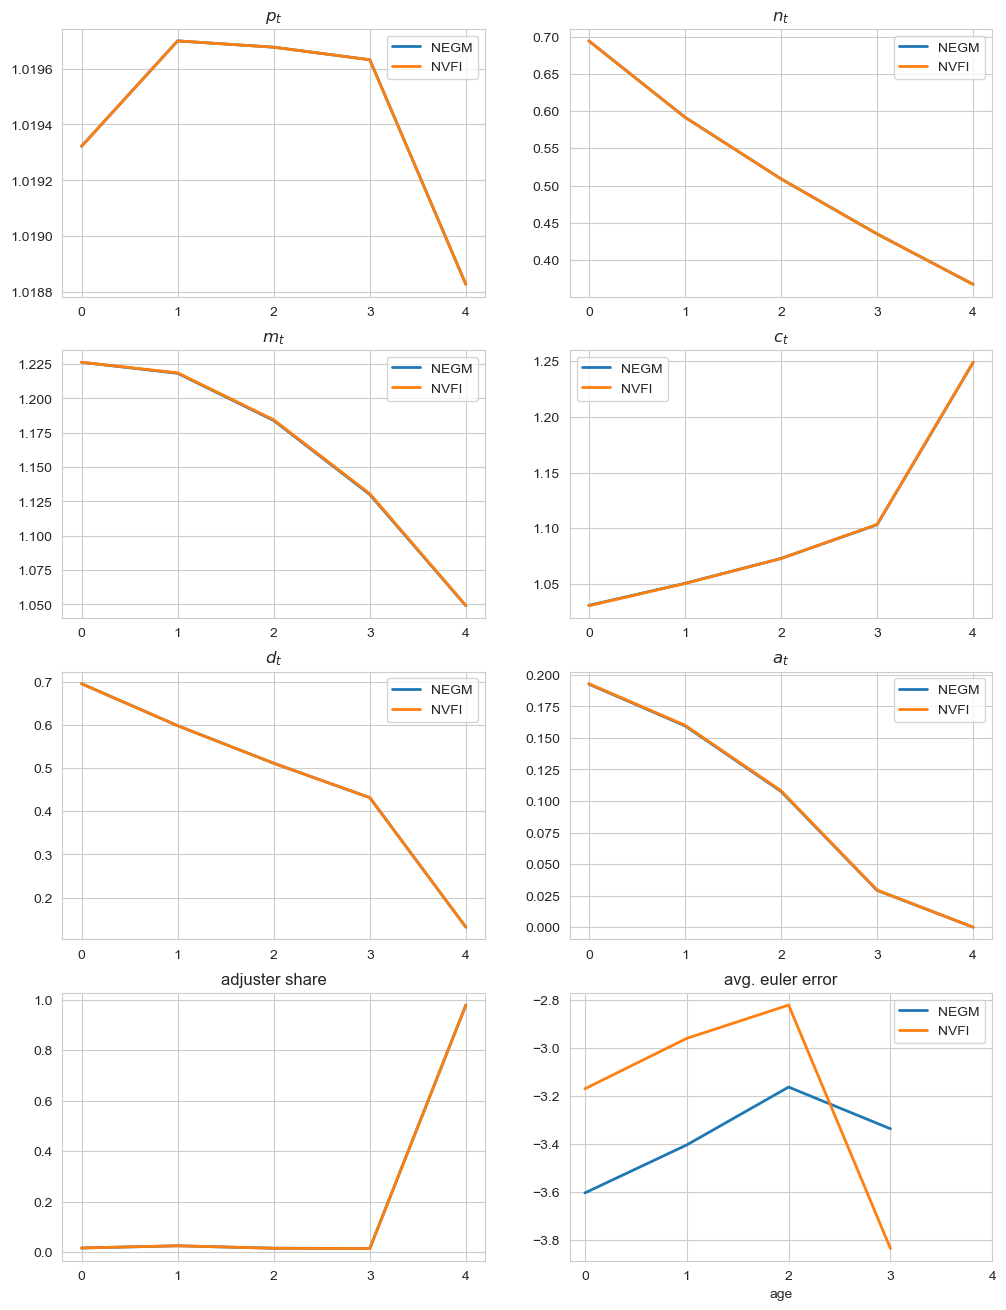

In [11]:
from figs import lifecycle_compare
lifecycle_compare(models['negm'],'NEGM',models['nvfi'],'NVFI',do_euler_errors=True)